## Readme
1. 建立文件夹
2. 复制模型以及 Geometry 文件
   1. 先判断文件是否存在再复制

3. 定义传感器编号和环节的对应关系
4. 将 LMPS 坐标转换为 OpenSense 坐标 --》查找先前代码
5. 将 LMPS 文件转换为 .sto 文件

6. 运行 OpenSense 代码 --》查找先前代码
7. 在 OpenSim 中打开逆运动学结果

In [163]:
# 读取相对应的包
import os
import shutil
import pandas as pd

In [164]:
dir_path = "/Users/wangshuaibo/Library/CloudStorage/OneDrive-bsu.edu.cn/Archive/代码_OpenSense/OpenSense_Python/OpenSenseExample"
opensense_example_dir = "OpenSenseExample_Original"

In [165]:
# newfile_name = input("请输入新建文件夹名称：")
newfile_name = "20230615_LMPS_NoTorsoRightFeet"
newfile_path = os.path.join(dir_path, newfile_name)

In [166]:
# 新建文件夹
os.makedirs(newfile_path,exist_ok=True)

In [167]:

file_name = "20230620_walk6step_50hz.csv"
frame_rate = 50

IMUData_dir = "IMUData"
file_path = os.path.join(dir_path,newfile_name,IMUData_dir,file_name)

In [168]:
# 匹配传感器名称和环节部位
# bodies = ["pelvis","tibia_r","femur_r","tibia_l",'femur_l','calcn_l']
# sensors = [1, 5, 3, 4, 2, 6]
bodies = ["pelvis","tibia_r","femur_r","tibia_l",'femur_l']
sensors = [1, 5, 3, 4, 2]
bodies_sensors = dict(zip(bodies,sensors))

## 读取传感器数值

In [169]:
df = pd.read_csv(file_path)
df.columns

Index(['SensorId', ' TimeStamp (s)', ' FrameNumber', ' AccX (g)', ' AccY (g)',
       ' AccZ (g)', ' GyroX (deg/s)', ' GyroY (deg/s)', ' GyroZ (deg/s)',
       ' MagX (uT)', ' MagY (uT)', ' MagZ (uT)', ' EulerX (deg)',
       ' EulerY (deg)', ' EulerZ (deg)', ' QuatW', ' QuatX', ' QuatY',
       ' QuatZ', ' LinAccX (g)', ' LinAccY (g)', ' LinAccZ (g)',
       ' Pressure (kPa)', ' Altitude (m)', ' Temperature (degC)',
       ' HeaveMotion (m)'],
      dtype='object')

<Axes: >

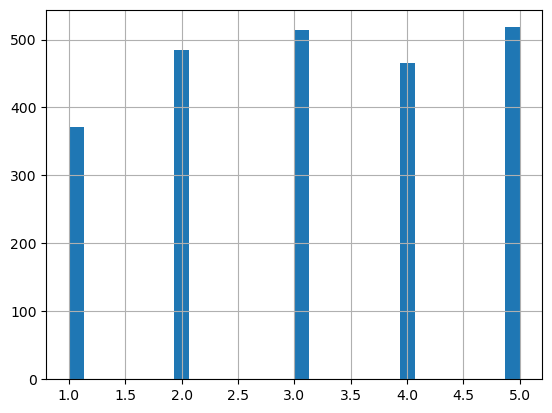

In [170]:
# 查看丢包情况
df["SensorId"].hist(bins=30)

## 转换传感器四元数坐标

In [180]:
# 定义四元数相乘函数
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return (w, x, y, z)

In [235]:
# 转换小蓝块坐标为opensense 坐标系格式
import numpy as np 

# 定义数值
quats = [' QuatW', ' QuatX', ' QuatY', ' QuatZ']
quats_value = df[quats].values

# 将小蓝块东北天(ENU)坐标系转换到北西天(NWU)坐标系
# 全局坐标系即沿着 Z 轴旋转90度，数值为正
# 此处应该为静态旋转即外旋？因而应该是右乘？
# angle_NWU2ENU = -np.pi/2
# q_NWU2ENU = (np.cos(angle_NWU2ENU/2),0,0,np.sin(angle_NWU2ENU/2))
q_NWU2ENU = [-0.70710678, 0  , -0 , -0.70710678]
result_NWU2ENU = quaternion_multiply( quats_value.T, q_NWU2ENU)

'''
# 将传感器方向转换为 Xsens 规定方向
# 传感器绕着 y 轴旋转 180度
angle_opensense = np.pi  # 180度等于π弧度
q_y180 = (np.cos(angle_opensense / 2), 0, np.sin(angle_opensense / 2), 0)
result_opensense = quaternion_multiply(result_NWU2ENU, q_y180)

angle_opensense1 = -np.pi/2
z_c_y90 = (np.cos(angle_opensense / 2), 0, 0, np.sin(angle_opensense / 2))
result_opensense1 = quaternion_multiply(result_opensense, z_c_y90)
'''

result_trans = result_NWU2ENU
# 将结果转换为DataFrame
tran_quats = ["trans q0","trans q1","trans q2","trans q3"]
df[tran_quats] = pd.DataFrame(list(result_trans)).transpose() 

In [236]:
df[quats]

,QuatW,QuatX,QuatY,QuatZ
0,-0.692141,-0.121070,-0.704944,-0.096630
1,-0.691996,-0.121138,-0.705159,-0.096011
2,-0.691938,-0.121318,-0.705214,-0.095800
3,-0.690336,-0.123093,-0.706259,-0.097383
4,0.479100,-0.452900,0.563600,-0.497500
...,...,...,...,...
2349,-0.508741,0.011279,-0.789694,0.342692
2350,-0.573500,0.464600,-0.544100,0.398800
2351,0.557100,-0.468500,0.543700,-0.417500
2352,-0.573300,0.464300,-0.544700,0.398600


In [237]:
df[tran_quats]

,trans q0,trans q1,trans q2,trans q3
0,0.421090,0.584080,0.412861,0.557746
1,0.421425,0.584280,0.412965,0.557205
2,0.421533,0.584446,0.412877,0.557015
3,0.419281,0.586440,0.412360,0.557001
4,-0.690560,-0.078277,-0.718774,0.013011
...,...,...,...,...
2349,0.602054,0.550423,0.566374,0.117414
2350,0.687520,0.056215,0.713259,0.123532
2351,-0.689146,-0.053174,-0.715733,-0.098712
2352,0.687237,0.056851,0.713471,0.123532


## 提取不同传感器转换后数值

In [238]:
# 将不同传感器的数值保存在不同的列
new_df = pd.DataFrame()
series = pd.Series(dtype="float64")
for body in bodies:
    sensor_id = bodies_sensors[body]
    body_quats = [body + " " + quat for quat in tran_quats]
    # 先重置index
    temp_df = df[df['SensorId'] == sensor_id][quats].reset_index(drop=True)
    # 长度不一样只能使用 concat 连接
    new_df = pd.concat([new_df,temp_df], axis=1)


new_df.columns =  [body + " " + quat for body in bodies for quat in tran_quats]
new_df

,pelvis trans q0,pelvis trans q1,pelvis trans q2,pelvis trans q3,tibia_r trans q0,tibia_r trans q1,tibia_r trans q2,tibia_r trans q3,femur_r trans q0,femur_r trans q1,femur_r trans q2,femur_r trans q3,tibia_l trans q0,tibia_l trans q1,tibia_l trans q2,tibia_l trans q3,femur_l trans q0,femur_l trans q1,femur_l trans q2,femur_l trans q3
0,-0.640209,-0.232242,-0.665728,-0.304962,-0.0955,0.4783,-0.1974,0.8503,0.4791,-0.4529,0.5636,-0.4975,-0.469760,0.050492,-0.853544,0.219632,-0.692141,-0.121070,-0.704944,-0.096630
1,-0.640176,-0.232421,-0.665492,-0.305410,-0.0979,0.4783,-0.1986,0.8497,0.4799,-0.4520,0.5651,-0.4959,-0.469765,0.050597,-0.853512,0.219724,-0.691996,-0.121138,-0.705159,-0.096011
2,-0.640107,-0.232609,-0.665295,-0.305841,-0.1002,0.4784,-0.2001,0.8491,0.4807,-0.4511,0.5666,-0.4942,-0.469755,0.050685,-0.853488,0.219818,-0.691938,-0.121318,-0.705214,-0.095800
3,-0.640182,-0.233081,-0.665029,-0.305903,-0.1026,0.4785,-0.2016,0.8484,0.4814,-0.4501,0.5681,-0.4926,-0.469749,0.050758,-0.853461,0.219916,-0.690336,-0.123093,-0.706259,-0.097383
4,-0.640101,-0.233245,-0.664870,-0.306292,-0.1049,0.4786,-0.2032,0.8476,0.4820,-0.4494,0.5696,-0.4910,-0.469731,0.050848,-0.853436,0.220032,-0.690338,-0.122978,-0.706280,-0.097362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,NaN,NaN,NaN,NaN,-0.5739,0.4649,-0.5433,0.3990,0.5571,-0.4685,0.5437,-0.4175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514,NaN,NaN,NaN,NaN,-0.5737,0.4647,-0.5437,0.3989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,NaN,NaN,NaN,NaN,-0.5735,0.4646,-0.5441,0.3988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,NaN,NaN,NaN,NaN,-0.5733,0.4643,-0.5447,0.3986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [239]:
# 新增 time 列
time = np.arange(0, new_df.shape[0]/frame_rate, 1/frame_rate)
new_df.insert(0,"time",time,)
# 去除包含空行的数据

new_df.dropna(axis=0,inplace=True)
# 保存文件
tran_file_path = os.path.splitext(file_path)[0] + "_coordinate_trans.csv"
new_df.to_csv(tran_file_path,index=False)

## 复制OpenSim 模型文件

In [240]:
# 复制模型
src_Geometry = os.path.join(dir_path,opensense_example_dir,"Geometry")
dst_Geometry = os.path.join(dir_path,newfile_name,"Geometry")

src_model = os.path.join(dir_path,opensense_example_dir,"Rajagopal_2015.osim")
dst_model = os.path.join(dir_path,newfile_name,"Rajagopal_2015.osim")

shutil.copytree(src_Geometry, dst_Geometry,dirs_exist_ok=True)
shutil.copy2(src_model, dst_model)

'/Users/wangshuaibo/Library/CloudStorage/OneDrive-bsu.edu.cn/Archive/代码_OpenSense/OpenSense_Python/OpenSenseExample/20230615_LMPS_NoTorsoRightFeet/Rajagopal_2015.osim'

In [241]:
# 设置opensim 对应的表头
# 设置表头
bodies_imu = [body+"_imu" for body in bodies]

opensim_sto_columns = "time\t"
for body_imu in bodies_imu:
    opensim_sto_columns = opensim_sto_columns + body_imu + "\t"

opensim_sto_columns = opensim_sto_columns.strip() + "\n"

In [242]:
# frame_rate = 100
meatdata = f"""DataRate={frame_rate:.6f}
DataType=Quaternion
version=3
OpenSimVersion=4.4-2022-10-11-798caa8
endheader
"""
header = meatdata + opensim_sto_columns
header

'DataRate=50.000000\nDataType=Quaternion\nversion=3\nOpenSimVersion=4.4-2022-10-11-798caa8\nendheader\ntime\tpelvis_imu\ttibia_r_imu\tfemur_r_imu\ttibia_l_imu\tfemur_l_imu\n'

In [243]:
old_filename = tran_file_path
newfile_path = os.path.splitext(file_path)[0] + ".sto"

In [244]:
# 先写入表头内容
with open(newfile_path,"w") as new_f:
    new_f.write(header)
# 写入四元数数据
with open(tran_file_path, "r") as old_f, open(newfile_path, "a") as new_f:
    line_index = 0
    for line in old_f:
        # 去除第一行的表头不进行记录
        line_index += 1
        if line_index > 1:
            new_line = line.split(",")
            # print(new_line)
            str_new = ""
            index = 0
            for i in new_line:
                if index % 4 == 0:
                    str_new = str_new + i.strip() + "\t"
                else:
                    str_new = str_new + i.strip() + ","
                index = index + 1
            new_f.write(str_new.strip()+"\n")